In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from consts import res,lat,log
from utils import get_year_heatmap,generate_date_dataframe,draw_rat_heatmap,draw_pics,draw_rat_heatmaps,get_year_dataframes
import utils
import torch
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import cvxpy as cvx
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg

In [2]:
df = utils.get_data('rat')
df['New_Date'] = pd.to_datetime(df['Created Date'])

In [17]:
df_list = []
year_pic_list = []
for i in range(9):
    tmp_df=get_year_dataframes(df,2010+i)
    year_pic_list.append(draw_rat_heatmaps(tmp_df,20))

In [18]:
year_pic_list = np.array(year_pic_list)
print(year_pic_list.shape)

(9, 12, 20, 20)


In [20]:
# 划分训练集和测试集
res = 20
train_set = year_pic_list[:5]
test_set = year_pic_list[-4:]
print(train_set.shape,test_set.shape)
train_set = train_set.reshape(-1,res*res)
test_set = test_set.reshape(-1,res*res)
print(train_set.shape)
print(test_set.shape)

(5, 12, 20, 20) (4, 12, 20, 20)
(60, 400)
(48, 400)


In [22]:
X = train_set[0]
X = X.reshape(res,res)
ny,nx = X.shape
ri = np.random.choice(res*res,round(res*res*0.5),replace=False)
b = X.T.flat[ri]



In [23]:

def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)


def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)


A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
)
A = A[ri,:]

In [25]:
vx = cvx.Variable(nx*ny)
objective = cvx.Minimize(cvx.norm(vx,1))
constraints = [A * vx == b]
prob = cvx.Problem(objective,constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()
Xat = Xat2.reshape(res,res)
Xa = idct2(Xat)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 800, constraints m = 1000
          nnz(P) + nnz(A) = 81600
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.2000e+03   8.00e+00   5.63e+04   1.00e-01   1.87e-02s
 200   2.0589e+02   2.95e-02   5.48e-04   1.74e-02   7.65e-02s
 400   2.0587e+02   1.30e-02   2.60e-04   

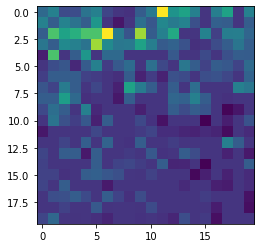

In [26]:
plt.imshow(Xa)

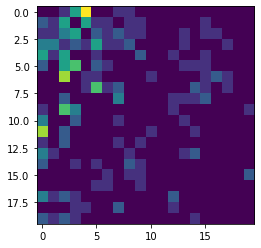

In [27]:
plt.imshow(X)

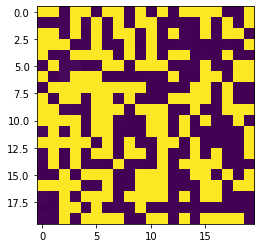

In [28]:
mask = np.zeros(X.shape)
mask.T.flat[ri] = 255
Xm = 255 * np.ones(X.shape)
Xm.T.flat[ri] = X.T.flat[ri]
plt.imshow(Xm)

In [31]:
((X-Xa)**2).sum()

727.3450665810135